<a href="https://colab.research.google.com/github/AikenChung/microBE/blob/main/phyla_data_PCA_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Take PMI (pointwise mutual information) filtered and 
CLR (centered log-ratio) normalized phyla microbiome count data as the input data to visualize it using PCA and UMAP.
 
**Team: microBE**

@Ali, @Anthony, @Laura, @Aiken


In [ ]:
colab = True
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
############################ UMAP Setting ######################################

inputFile = '/content/drive/MyDrive/ColabNotebooks/phyla_stool_noNC_3265x1177_PMI_threshold_0_clr_plsda.csv'
# Select the index value of the readout defined in the "col_name_list"
col_data_select_Index = 0  # index value should be from 0~4
col_name_list = ['col_site', 'diagnosis', 'stool_biopsy', 'studyID', 'uc_cd']
marker_size = 2
legend_marker_size = 5
################################################################################


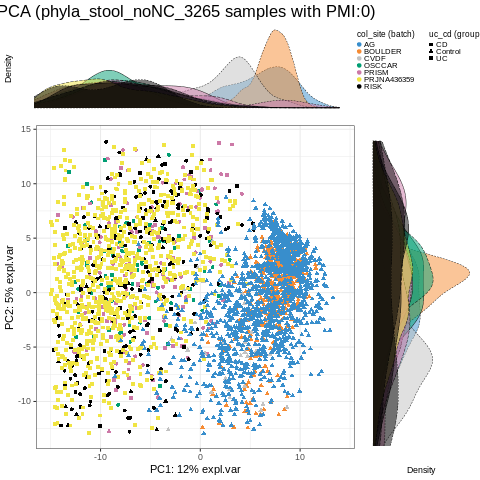

In [ ]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("mixOmics")
list.of.packages <- c("mixOmics", "ggplot2", "gridExtra")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) BiocManager::install(new.packages)

library(ggplot2) # For plot
library(gridExtra) # For plot with density
library(mixOmics) # For PCA

############################# PCA Setting ######################################
# Prepare input data and get data ready
phyla_dataset_d3_pmi_clr <- read.csv('/content/drive/MyDrive/ColabNotebooks/phyla_stool_noNC_3265x1177_PMI_threshold_0_clr_plsda.csv', 
                                     row.names=1, header=T, check.names=FALSE)

PCA_graph_title <- 'PCA (phyla_stool_noNC_3265 samples with PMI:0)'
################################################################################


phyla.pmi.clr <- data.matrix(phyla_dataset_d3_pmi_clr[,1:1177], rownames.force = NA)
phyla.pmi.clr.metadata <- phyla_dataset_d3_pmi_clr[,1178:1183]
names(phyla.pmi.clr) <- row.names(phyla.pmi.clr.metadata)

# Color codes for different variables
batch_color_col_site <- c('OSCCAR' = 'lightsalmon2',
                          'PRISM' = 'blue',
                          'RISK' = 'yellow',
                          'MGH' = 'lightslateblue',
                          'Cedars-Sinai' = 'limegreen',
                          'Cincinnati' = 'magenta2',
                          'MGH Pediatrics' = 'mediumorchid4',
                          'BOULDER' = 'navajowhite2',
                          'North Carolina' = 'olivedrab',
                          'CVDF' = 'red',
                          'paneth_cells' = 'green1',
                          'PRJNA436359' = 'darkturquoise',
                          'AG' = 'darkgreen')

batch_color_stool_biopsy <- c('stool' = 'darkgrey', 'biopsy' = 'darkred')
batch_color_studyID <- c('GEVERSM' = 'yellow', 
                         'HMP' = 'lightslateblue',
                         'GEVERSC' = 'limegreen', 
                         'QIITA550' = 'magenta2',
                         'QIITA2202' = 'mediumorchid4', 
                         'CVDF' = 'navajowhite2',
                         'MUC' = 'olivedrab', 
                         'PRJNA436359' = 'red',
                         'AG' = 'green1')
group_color_uc_cd <- c('Control' = 'springgreen', 
                       'CD' = 'dodgerblue3', 
                       'UC' = 'deeppink')

# Set batch effect variable and the %load_ext rpy2.ipythonobserving group
batch_effect_variable <- phyla.pmi.clr.metadata$col_site
total_batch_num <- length(unique(phyla.pmi.clr.metadata$col_site))
observing_group <- phyla.pmi.clr.metadata$uc_cd

# Extract batch effect variables and observing group as factors
phyla.batch <- as.factor(batch_effect_variable)
names(phyla.batch) <- row.names(phyla.pmi.clr)
phyla.group <- as.factor(observing_group)
names(phyla.group) <- row.names(phyla.pmi.clr)


#---------------------------------------------------------------------
# Principal component analysis (PCA) with density plots per component
#---------------------------------------------------------------------
Scatter_Density <- function(data = data, batch = batch, trt = NULL, expl.var = expl.var,
                            xlim = xlim, ylim = ylim, batch.legend.title = 'Batch', 
                            trt.legend.title = 'Treatment', density.lwd = 0.2,
                            title = NULL, title.cex = 1.5, legend.cex = 0.7, legend.title.cex =0.75){
  data = as.data.frame(data)
  batch = as.factor(batch)
  trt = as.factor(trt)
  if(nlevels(trt) >= 2){
    pMain <- ggplot(data = data, aes(x = data[ ,1], y = data[ ,2], colour = batch, shape = trt)) + 
      geom_point() + xlab(paste0('PC1: ', round(as.numeric(expl.var[1])*100), '% expl.var')) + 
      ylab(paste0('PC2: ', round(as.numeric(expl.var[2])*100), '% expl.var')) + 
      scale_color_manual(values = color.mixo(1:18)) + theme_bw() + xlim(xlim[1], xlim[2]) + 
      ylim(ylim[1], ylim[2]) + labs(colour = batch.legend.title, shape = trt.legend.title) #+
    #scale_shape_manual(values=seq(0,15))
    
    pTop <- ggplot(data,aes(x = data[ ,1], fill = batch, linetype = trt)) + 
      geom_density(size = density.lwd, alpha = 0.5) + ylab('Density') + 
      theme(axis.title.x = element_blank(), axis.title.y = element_text(size = rel(0.8)), 
            plot.title = element_text(hjust = 0.5, size = rel(title.cex)), 
            axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(),
            panel.background = element_blank()) + scale_fill_manual(values = color.mixo(1:18)) +
      xlim(xlim[1], xlim[2]) + labs(title = title)
    
    pRight <- ggplot(data, aes(x=data[ ,2], fill = batch, linetype = trt)) + 
      geom_density(size = density.lwd,alpha = 0.5) +  coord_flip() + ylab('Density') +
      theme(axis.title.x = element_text(size = rel(0.8)), 
            axis.title.y = element_blank(), axis.line = element_blank(),
            axis.text = element_blank(), axis.ticks = element_blank(),
            panel.background = element_blank()) + scale_fill_manual(values = color.mixo(1:18)) +
      xlim(ylim[1], ylim[2])
  }else{
    pMain <- ggplot(data = data, aes(x = data[ ,1], y=data[ ,2], colour = batch)) + 
      geom_point(shape = 16) + xlab(paste0('PC1: ', round(as.numeric(expl.var[1])*100), '% expl.var')) + 
      ylab(paste0('PC2: ', round(as.numeric(expl.var[2])*100), '% expl.var')) + 
      scale_color_manual(values = color.mixo(1:18)) + theme_bw() + xlim(xlim[1], xlim[2]) + 
      ylim(ylim[1], ylim[2]) + labs(colour = batch.legend.title) #+ scale_shape_manual(values=seq(0,15))
    
    pTop <- ggplot(data, aes(x = data[ ,1], fill = batch)) + 
      geom_density(size = density.lwd, alpha=0.5) + ylab('Density') + 
      theme(axis.title.x = element_blank(), axis.title.y = element_text(size = rel(0.8)), 
            plot.title = element_text(hjust = 0.5, size = rel(title.cex)), 
            axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(),
            panel.background = element_blank()) + scale_fill_manual(values = color.mixo(1:18)) +
      xlim(xlim[1], xlim[2]) + labs(title = title)
    
    pRight <- ggplot(data, aes(x=data[ ,2], fill = batch)) + 
      geom_density(size = density.lwd, alpha = 0.5) +  coord_flip() + ylab('Density') +
      theme(axis.title.x = element_text(size = rel(0.8)), 
            axis.title.y = element_blank(), axis.line = element_blank(),
            axis.text = element_blank(), axis.ticks = element_blank(),
            panel.background = element_blank()) + scale_fill_manual(values = color.mixo(1:18)) +
      xlim(ylim[1], ylim[2])
  }
  
  
  g <- ggplotGrob(pMain + theme(legend.position = 'right', legend.box = 'horizontal',
                                legend.direction = 'vertical', 
                                legend.key.height = unit(0.2, 'cm'),
                                legend.key.width = unit(0.1, 'cm'),
                                legend.title = element_text(size = rel(legend.title.cex)),
                                legend.spacing.x = unit(0.1, 'cm'),
                                legend.spacing.y = unit(0.1, 'cm'),
                                legend.text = element_text(size = rel(legend.cex))))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  
  grid.arrange(pTop + theme(legend.position = 'none'), legend, pMain + 
                 theme(legend.position = 'none'), pRight + theme(legend.position = 'none'), 
               ncol = 2, nrow = 2, widths = c(3, 1), heights = c(1, 3))
  
}


#==================== PCA ===========================
phyla.pca.plsda <- pca(phyla.pmi.clr, ncomp = 3)


Scatter_Density(data = phyla.pca.plsda$variates$X, batch = phyla.batch,
                trt = phyla.group, expl.var = phyla.pca.plsda$explained_variance,
                xlim = c(-15,14), ylim = c(-13,14),
                batch.legend.title = 'col_site (batch)',
                trt.legend.title = 'uc_cd (group)',
                title = PCA_graph_title)






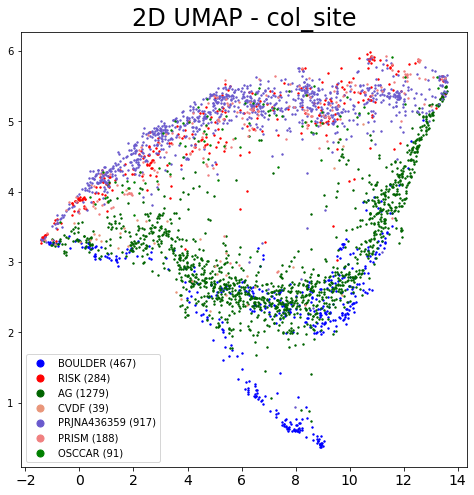

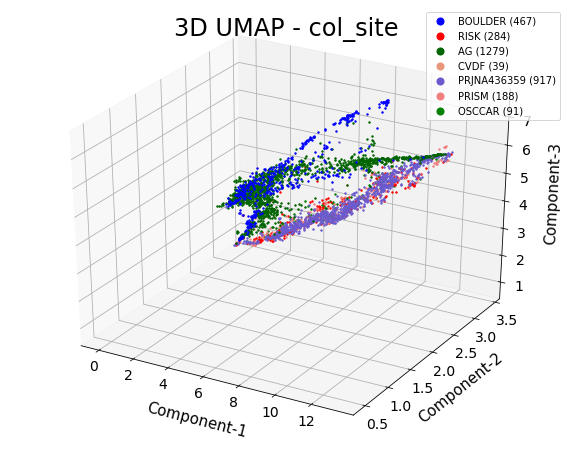

In [ ]:
##############################################################################
# UMAP Plotting
##############################################################################

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

norm_data_df = pd.read_csv(inputFile)


data_value_df = norm_data_df.iloc[:, 1:1178].copy()
metaData_df = norm_data_df.iloc[:, 1178:1185].copy()

row_num, col_num = metaData_df.shape

col_site_list = []
diagnosis_list = []
stool_biopsy_list = []
studyID_list =[]
uc_id_list = []
col_data_list = [col_site_list, diagnosis_list, stool_biopsy_list, studyID_list, uc_id_list]



for index, row in metaData_df.iterrows():
    col_site_list.append(row['col_site'])
    if row['diagnosis'] > 0:
        diagnosis_list.append('Yes')
    else:
        diagnosis_list.append('No')
    stool_biopsy_list.append(row['stool_biopsy'])
    studyID_list.append(row['studyID'])
    uc_id_list.append(row['uc_cd'])
    
data_group_list = []
for i in range(row_num):
       data_group_list.append(col_data_list[col_data_select_Index][i])

group_name_list = ['col_site_Group', 'diagnosis_Group', 'stool_biopsy_Group', 'studyID_Group', 'uc_cd_Group']

targets = []
targets_label = []
colors = []
# https://python-graph-gallery.com/python-colors/
color_universe = ['blue', 'red','darkgreen','darksalmon', 
                  'slateblue', 'lightcoral', 'g', 'orange',
                  'mediumblue', 'darkred', 'springgreen', 'orangered',
                  'steelblue', 'tomato', 'limegreen', 'orchid']

data_value_df[group_name_list[col_data_select_Index]] = data_group_list

from collections import Counter
val_count = Counter(data_group_list)
targets = list(set(data_group_list))

for i in range(len(targets)):
    targets_label.append(targets[i]+ " ("+str(val_count[targets[i]])+")")
    colors.append(color_universe[i])



##############################################################################
# 2D UMAP 
##############################################################################

import umap as umap2D

reducer = umap2D.UMAP()

readCount_Data = data_value_df.iloc[:, 0:1177].copy().values

scaled_readCount_Data = StandardScaler().fit_transform(readCount_Data)

embedding = reducer.fit_transform(scaled_readCount_Data)
embedding.shape


fig0 = plt.figure(figsize = (8,8))
plot0 = fig0.add_subplot(1,1,1)
for target, color in zip(targets,colors):
    indicesToKeep = data_value_df[group_name_list[col_data_select_Index]] == target
    plot0.scatter(
        embedding[indicesToKeep, 0],
        embedding[indicesToKeep, 1],
        c=color,
        s=marker_size)
plot0.set_title('2D UMAP - ' + col_name_list[col_data_select_Index], fontsize=24)
plot0.legend(targets_label,markerscale=legend_marker_size)



##############################################################################
# 3D UMAP 
##############################################################################

import umap as umap3D

reducer2 = umap3D.UMAP(n_components=3)

embedding2 = reducer2.fit_transform(scaled_readCount_Data)
embedding2.shape

fig1 = plt.figure(figsize = (10,8))
plot1 = fig1.add_subplot(111, projection='3d')
plot1.set_xlabel('\nComponent-1', fontsize = 15)
plot1.set_ylabel('\nComponent-2', fontsize = 15)
plot1.set_zlabel('\nComponent-3', fontsize = 15)
plot1.tick_params(axis='x', which='major', pad=0.01)
plt.rc('xtick',labelsize=14)


for target, color in zip(targets,colors):
    indicesToKeep = data_value_df[group_name_list[col_data_select_Index]] == target
    plot1.scatter(
        embedding2[indicesToKeep, 0],
        embedding2[indicesToKeep, 1],
        embedding2[indicesToKeep, 2],
        c=color,
        s=marker_size,
        depthshade = False)
plot1.set_title('3D UMAP - ' + col_name_list[col_data_select_Index], fontsize=24)
plot1.legend(targets_label,markerscale=legend_marker_size)
#plot1.view_init(10, 60)
#Fig1


